# Kaggle - Facial Keypoints Detector

[Facial Keypoints Detector](https://www.kaggle.com/c/facial-keypoints-detector)



In [65]:
import tensorflow as tf
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd

In [ ]:
# importing samples from Google Drive
!pip install -U -q PyDrive

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
import os

# PyDrive Authentication
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# define folder id
folder_id = 'folder id'

# file_lists will be my list of files from folder
file_lists = []

# get lists of files from Google Drive folder
def ListFolder(parent):
    filelist=[]
    file_list = drive.ListFile({'q': "'%s' in parents and trashed=false" % parent}).GetList()
    for f in file_list:
        if f['mimeType']=='application/vnd.google-apps.folder': # if folder
            filelist.append({"id":f['id'],"title":f['title'],"list":ListFolder(f['id'])})
        else:
            filelist.append({"title":f['title'],"id":f['id']})
    return filelist

file_lists_from_drive = ListFolder(folder_id)

# choose a local (colab) directory to store the data.
local_download_path = os.path.expanduser('~/my_sample_data')
try:
    os.makedirs(local_download_path)
except: pass


for file in file_lists_from_drive:
    fname = os.path.join(local_download_path, file['title'])
    f_ = drive.CreateFile({'id': file['id']})
    f_.GetContentFile(fname)
    file_lists.append(fname)

print(file_lists)

In [2]:
# import sample data from local PC
import os

folder_path = './data/'
flists = os.listdir(folder_path)
file_lists =[os.path.join(folder_path, fname) for fname in flists]

In [3]:
sorted(file_lists, key=str.lower)

['./data/kaggle_facial_keypoints_detector_test.csv',
 './data/kaggle_facial_keypoints_detector_train.csv',
 './data/kaggle_facial_keypoints_detector_train_identity.csv']

In [4]:
print(file_lists)

['./data/kaggle_facial_keypoints_detector_test.csv', './data/kaggle_facial_keypoints_detector_train_identity.csv', './data/kaggle_facial_keypoints_detector_train.csv']


In [5]:
train = pd.read_csv(file_lists[2])
test = pd.read_csv(file_lists[0])

In [6]:
train.head()

,Emotion,Pixels
0,3,221 240 251 254 255 255 255 255 255 255 255 25...
1,6,100 107 108 104 103 113 117 115 120 130 138 14...
2,4,35 50 56 57 63 76 74 79 85 86 105 133 145 152 ...
3,6,119 124 129 135 136 140 142 149 159 156 163 16...
4,2,160 173 186 194 188 185 175 162 153 143 135 12...


In [7]:
X_train = train['Pixels']
y_train = train['Emotion']

In [8]:
X_train.shape, y_train.shape

((4178,), (4178,))

In [9]:
def convert_to_float32(arr):
    ret = []
    for col in arr:
        a = col.split(' ')
        ret.append(a)
    ret = [[int(x) for x in col.split(' ')] for col in arr]
    return np.array(ret, np.float32)

In [10]:
X_train = convert_to_float32(X_train)

In [11]:
X_train.shape

(4178, 2304)

In [46]:
X_train = X_train.reshape(-1, 48, 48, 1)
y_train = y_train.reshape(-1, 1).astype(np.int32)
print(X_train.shape, y_train.shape)

(4178, 48, 48, 1) (4178, 1)


### CNN Model

L1: filter_size=5X5, strides=1, features=32, max_pool= 2X2 strides=2
L2: filter_size=3X3, strides=1, features=64, max_pool= 2X2 strides=2
FC: output=1024
OUTPUT

Loss Function = cross_entropy
activation = softmax

In [17]:
# parameters
BATCH_SIZE = 128
LEARNING_RATE = 1e-3
TRAINING_EPOCH = 1001
KEEP_PROB = 0.75

In [18]:
X = tf.placeholder(tf.float32, shape=[None, 48, 48, 1])
Y = tf.placeholder(tf.int32, shape=[None, 1])
drop_out = tf.placeholder(tf.float32)

In [50]:
Y_one_hot = tf.one_hot(Y, 7)
Y_one_hot = tf.reshape(Y_one_hot, shape=[-1, 7])

In [20]:
w1 = tf.Variable(tf.random_normal([5, 5, 1, 32]), tf.float32)

In [21]:
L1 = tf.nn.conv2d(X, w1, strides=[1, 1, 1, 1], padding='SAME')

In [22]:
L1 = tf.nn.relu(L1)

In [23]:
L1 = tf.nn.max_pool(L1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')

In [24]:
L1.shape

TensorShape([Dimension(None), Dimension(24), Dimension(24), Dimension(32)])

In [25]:
w2 = tf.Variable(tf.random_normal([3, 3, 32, 64]), tf.float32)

In [26]:
L2 = tf.nn.conv2d(L1, w2, strides=[1, 1, 1, 1], padding='SAME')

In [27]:
L2 = tf.nn.relu(L2)

In [28]:
L2 = tf.nn.max_pool(L2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')

In [29]:
L2.shape

TensorShape([Dimension(None), Dimension(12), Dimension(12), Dimension(64)])

In [30]:
w3 = tf.Variable(tf.random_normal([12*12*64, 1024]), tf.float32)

In [31]:
b3 = tf.Variable(tf.random_normal([1024]), tf.float32)

In [32]:
L2 = tf.layers.flatten(L2)
FC = tf.matmul(L2, w3)+ b3

In [33]:
FC.shape

TensorShape([Dimension(None), Dimension(1024)])

In [34]:
FC = tf.nn.relu(FC)

In [35]:
FC = tf.nn.dropout(FC, drop_out)

In [36]:
w4 = tf.Variable(tf.random_normal([1024, 7]), tf.float32)

In [37]:
b4 = tf.Variable(tf.random_normal([7]), tf.float32)

In [38]:
Logit = tf.matmul(FC, w4) + b4

In [39]:
Hypothesis = tf.nn.softmax(Logit)

In [53]:
Loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=Logit, labels=Y_one_hot))

In [41]:
Optimizer = tf.train.AdamOptimizer(LEARNING_RATE).minimize(Loss)

In [56]:
Prediction = tf.argmax(Hypothesis, 1)

In [57]:
Actual = tf.argmax(Y_one_hot, 1)

In [59]:
Accuracy = tf.reduce_mean(tf.cast(tf.equal(Prediction, Actual), tf.float32))

In [63]:
tf.summary.scalar('Loss', Loss)
tf.summary.scalar('Accuracy', Accuracy)
Summaries = tf.summary.merge_all()

In [64]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    summary_writer = tf.summary.FileWriter('logs/kaggle_facial_keypoints_detector', sess.graph)
    for epoch in range(TRAINING_EPOCH):
        dataset = Dataset(X_train, y_train)
        dx, dy = dataset.next_batch(BATCH_SIZE)
        _, loss, accuracy, summeries = sess.run([Optimizer, Loss, Accuracy, Summaries], feed_dict={X:dx, Y:dy, drop_out:KEEP_PROB})
        summary_writer.add_summary(summeries, global_step=epoch)
        if epoch % 10 == 0:
            print("EPOCH: {0}, Loss: {1:.5f}, Accuracy: {2:.5f}".format(epoch, loss, accuracy))

EPOCH: 0, Loss: 25145526.00000, Accuracy: 0.11719
EPOCH: 10, Loss: 10104240.00000, Accuracy: 0.15625
EPOCH: 20, Loss: 7834931.00000, Accuracy: 0.22656
EPOCH: 30, Loss: 6470991.50000, Accuracy: 0.18750
EPOCH: 40, Loss: 6011287.00000, Accuracy: 0.19531
EPOCH: 50, Loss: 4258662.00000, Accuracy: 0.27344
EPOCH: 60, Loss: 4220480.00000, Accuracy: 0.29688
EPOCH: 70, Loss: 3214868.00000, Accuracy: 0.28906
EPOCH: 80, Loss: 3160731.00000, Accuracy: 0.31250
EPOCH: 90, Loss: 2445706.50000, Accuracy: 0.39062
EPOCH: 100, Loss: 1790683.25000, Accuracy: 0.35938
EPOCH: 110, Loss: 2151585.00000, Accuracy: 0.39062
EPOCH: 120, Loss: 1506672.00000, Accuracy: 0.43750
EPOCH: 130, Loss: 1340079.87500, Accuracy: 0.46094
EPOCH: 140, Loss: 965394.93750, Accuracy: 0.57812
EPOCH: 150, Loss: 1089800.00000, Accuracy: 0.51562
EPOCH: 160, Loss: 791545.75000, Accuracy: 0.57812
EPOCH: 170, Loss: 691561.50000, Accuracy: 0.53125
EPOCH: 180, Loss: 705621.25000, Accuracy: 0.50781
EPOCH: 190, Loss: 496610.43750, Accuracy: 0.

In [48]:
dx.shape, dy.shape

((128, 48, 48, 1), (128, 1))

In [49]:
Y_one_hot.shape

TensorShape([Dimension(None), Dimension(1), Dimension(7)])

### Implementing next_batch

In [13]:
import numpy as np 

class Dataset:
    def __init__(self, images, labels):
        self._index_in_epoch = 0
        self._epochs_completed = 0
        self._images = images
        self._labels = labels 
        self._num_examples = train.shape[0]
        pass

    @property
    def images(self):
        return self._images
    
    @property
    def labels(self):
        return self._labels

    def next_batch(self, batch_size, shuffle=True):
        # mark start index
        start = self._index_in_epoch
        
        # if it's very first time in epoch
        if start == 0 and self._epochs_completed == 0 and shuffle:
            idx = np.arange(0, self._num_examples)  # get all possible indexes
            np.random.shuffle(idx)  # shuffle indexe
            self._images = self._images[idx]  # get list of `num` random samples
            self._labels = self._labels[idx]

        # go to the next epoch
        if start + batch_size > self._num_examples:
            # it is the last batch loop
            self._epochs_completed += 1
            
            # get the rest
            rest_num_examples = self._num_examples - start
            images_rest_part = self._images[start:self._num_examples]
            labels_rest_part = self._labels[start:self._num_examples]
            
            # newly shuffle images, labels for next epoch
            if shuffle:
                idx0 = np.arange(0, self._num_examples)  
                np.random.shuffle(idx0)  # shuffle indexes
                self._images = self._images[idx0]
                self._labels = self._labels[idx0]

            start = 0
            self._index_in_epoch = batch_size - rest_num_examples #avoid the case where the #sample != integar times of batch_size
            end =  self._index_in_epoch  
            images_new_part =  self._images[start:end]  
            labels_new_part =  self._labels[start:end]  
            
            return np.concatenate((images_rest_part, images_new_part), axis=0), numpy.concatenate((labels_rest_part, labels_new_part), axis=0)
        else:
            self._index_in_epoch += batch_size
            end = self._index_in_epoch
            return self._images[start:end], self._labels[start:end]

X_batch = X_train.copy()
Y_batch = y_train.copy()

dataset = Dataset(X_batch, Y_batch)
dx, dy = dataset.next_batch(10)   

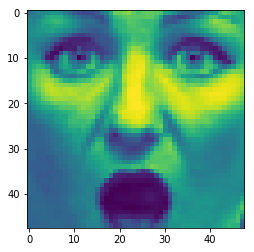

In [14]:
plt.imshow(dx[2].reshape([48, 48]))

### Visualize

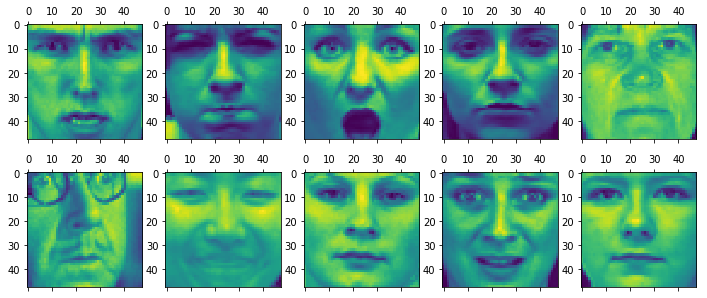

In [15]:
figure = plt.figure()
figure.set_size_inches(12, 5)

axes = []
for i in range(1, 11):
    axes.append(figure.add_subplot(2, 5, i))

for i in range(10):
    axes[i].matshow(dx[i].reshape(48, 48))

In [16]:
dy

array([[0],
       [0],
       [5],
       [6],
       [6],
       [5],
       [3],
       [6],
       [2],
       [6]])